# Barlow-Beeston method for MC stats in the likelihood

Here I'm going to test out the method laid out in section 5 of Conway (arXiv:1103.0354).  The section describes a method for accounting for statistical uncertainty on MC templates in a binned MLE fit.  The idea is that there is a nuisance parameter assigned to each bin ($\beta_{i}$) that can be solved for within the likelihood using the relation,

$$
\beta^{2} + (\mu\sigma_{\beta}^{2} - 1) - n\sigma_{\beta}^{2} = 0.
$$

That is, while other n.p. and parameters of interest are determined using a numerical gradient descent, the additional n.p. corresponding to statistical uncertainty can be solved analytically (assuming a Gaussian constraint).

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 53597,
  "iopub_port": 50841,
  "stdin_port": 40101,
  "control_port": 35779,
  "hb_port": 51587,
  "ip": "127.0.0.1",
  "key": "a116da4c-e36b57168b4e8bfe0e3c30e5",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-44ff29aa-8dc1-4a8c-b33e-ea08141ae527.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [14]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/updated_e_sf/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# set up fit configuration
# minimizer options
min_options = dict(#eps=1e-9, 
                   gtol = 1e-2,
                   disp = True
                  )

# configure the objective
fit_data._pmask[4:] = False
mask = fit_data._pmask.copy()
sample = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = False,
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = False,
                  )

In [4]:
# Asimov dataset and stats only fit
result_stat = minimize(fobj, params_pre[:4],
                       jac = fobj_jac,
                       method = 'BFGS', 
                       options = min_options,
                      )

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr_stat, _ = fh.calculate_covariance(fobj, params_pre[:4])
print(result_stat.x*100, stderr_stat*100/params_pre[:4])

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[10.8 10.8 10.8 67.6] [0.109 0.093 0.517 0.078]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)


In [5]:
# carry out the fit with bb
fobj.keywords['do_bb_lite'] = True
fobj_jac.keywords['do_bb_lite'] = True
result_stat_mc = minimize(fobj, params_pre[:4],
                          jac = fobj_jac,
                          method = 'BFGS', 
                          options = min_options,
                         )

# calculate covariance matrix from the inverse of the Hessian of the NLL
stderr_mc_stat, _ = fh.calculate_covariance(fobj, params_pre[:4])
print(result_stat_mc.x*100, np.sqrt(stderr_mc_stat**2 - stderr_stat**2)*100/params_pre[:4])

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[10.8 10.8 10.8 67.6] [0.076 0.065 0.438 0.068]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)


In [9]:
# carry out fit for n trials with random offsets for templates
fobj.keywords['do_bb_lite'] = False
fobj_jac.keywords['do_bb_lite'] = False
fobj.keywords['randomize_templates'] = True
fobj_jac.keywords['randomize_templates'] = True

ntrials = 50
results = []
cost = []
sv_accept = []
for _ in tqdm_notebook(range(ntrials)):
    
    # update random offsets
    for category, rnums in fit_data._rnum_cache.items():
        fit_data._rnum_cache[category] = np.random.randn(rnums.size)
        
    # carry out fit
    result = minimize(fobj, params_pre[:4],
                      jac = fobj_jac,
                      method = 'BFGS', 
                      options = min_options,
                     )
        
    print(fobj(params_pre[:4]), result.fun, result.x[:4])
    if result.success:
        results.append(result.x)
        cost.append(result.fun)
    else:
        print(result)

results = np.array(results)

Optimization terminated successfully.
         Current function value: 255.821321
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
256.172814589012 255.82132115337154 [0.108 0.108 0.108 0.676]
Optimization terminated successfully.
         Current function value: 217.105614
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
218.32101880107737 217.10561426708347 [0.108 0.108 0.109 0.675]
Optimization terminated successfully.
         Current function value: 280.024728
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
280.7049464706269 280.0247283207761 [0.108 0.108 0.108 0.676]
Optimization terminated successfully.
         Current function value: 288.853319
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
289.9769165143251 288.853319063352 [0.108 0.108 0.109 0.675]
Optimization terminated successfully.
         Current func

         Current function value: 270.062486
         Iterations: 8
         Function evaluations: 108
         Gradient evaluations: 93
270.49744986973485 270.0624864424205 [0.108 0.108 0.108 0.676]
      fun: 270.0624864424205
 hess_inv: array([[ 1.396e-08, -1.949e-10, -1.334e-08, -4.320e-10],
       [-1.949e-10,  1.005e-08, -1.446e-08,  4.608e-09],
       [-1.334e-08, -1.446e-08,  3.101e-07, -2.823e-07],
       [-4.317e-10,  4.608e-09, -2.823e-07,  2.782e-07]])
      jac: array([-0.018, -0.034, -0.004, -0.   ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 108
      nit: 8
     njev: 93
   status: 2
  success: False
        x: array([0.108, 0.108, 0.108, 0.676])
Optimization terminated successfully.
         Current function value: 262.732903
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
263.6476404114626 262.7329028043554 [0.108 0.108 0.108 0.676]
Optimization terminated successfully.
         Curre

In [10]:
bb_errs_toys = np.std(results - params_pre[:4], axis=0)
bb_errs_hess = np.sqrt(stderr_mc_stat**2 - stderr_stat**2)

print(bb_errs_toys, bb_errs_hess, sep='\n')

[8.596e-05 6.804e-05 5.036e-04 5.238e-04]
[8.175e-05 7.024e-05 4.729e-04 4.575e-04]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


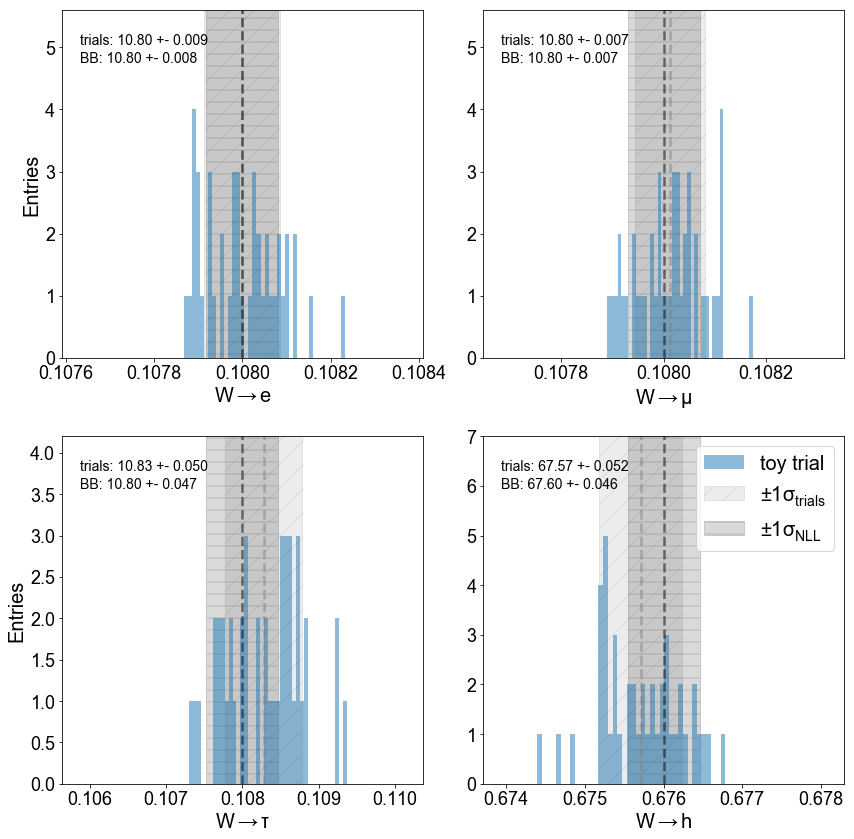

In [11]:
# produce plot for the note
fig, axes = plt.subplots(2, 2, figsize=(12, 12), facecolor='white')
nbins = 40
labels = [r'$W\rightarrow e$', r'$W\rightarrow \mu$', r'$W\rightarrow \tau$', r'$W\rightarrow h$']
for i in range(4):
    ax = axes[i//2][i%2]
    h, _, _ = ax.hist(results[:,i], bins=nbins, alpha=0.5, label='toy trial')
    bb_mean = results[:,i].mean()
    ax.plot([bb_mean, bb_mean], [0, 1.5*h.max()], color='gray', linestyle='--', alpha=0.5, label='_nolegend_')
    ax.fill_betweenx([0, 1.5*h.max()], bb_mean - bb_errs_toys[i],  bb_mean + bb_errs_toys[i], color='grey', hatch='/', alpha=0.15, label=r'$\pm 1\sigma_{trials}$')
    
    ax.plot([params_pre[i], params_pre[i]], [0, 1.5*h.max()], color='k', linestyle='--', alpha=0.5, label='_nolegend_')
    ax.fill_betweenx([0, 1.5*h.max()], params_pre[i] - bb_errs_hess[i],  params_pre[i] + bb_errs_hess[i], color='k', hatch='-', alpha=0.15, label=r'$\pm 1\sigma_{NLL}$')
    
    ax.text(0.05, 0.9, f'trials: {100*bb_mean:.2f} +- {100*bb_errs_toys[i]:.3f}', fontsize=14, transform=ax.transAxes)
    ax.text(0.05, 0.85, f'BB: {100*params_pre[i]:.2f} +- {100*bb_errs_hess[i]:.3f}', fontsize=14, transform=ax.transAxes)
    
    ax.set_xbound(params_pre[i] - 5*bb_errs_hess[i], params_pre[i] + 5*bb_errs_hess[i])
    ax.set_ybound(0., 1.4*h.max())
    ax.set_xlabel(labels[i])
    
    if i%2 == 0:
        ax.set_ylabel('Entries')
        
    if i == 3:
       plt.legend() 

plt.tight_layout()
plt.savefig('plots/systematics/bb_lite_validation.pdf')
plt.show()